In [1]:
from pyts.datasets import load_gunpoint
import matplotlib.pyplot as plt
import numpy as np
import mass_ts as mts

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn import svm
from sklearn.metrics import f1_score

/Users/stefan-temp/Desktop/General/Privat/greedy-shapelet-search/venv-hyp-mar/lib/python3.9/site-packages/mass_ts/_mass_ts.py:17: UserWarning: GPU support will not work. You must pip install mass-ts[gpu].
  warnings.warn(


In [2]:
X_train, X_test, y_train, y_test = load_gunpoint(return_X_y=True)

Goal:
Implement shapelet algorithm
Which set of shapelets is optimal

Ideas:
- mass algorithm for distance calculation
- greedy implementation (add next best fit until some criteria)
- divide and conquer
- bootstrapping 

1. sample 

In [3]:
y_train

array([2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1,
       1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1,
       2, 2, 1, 2, 1, 2])

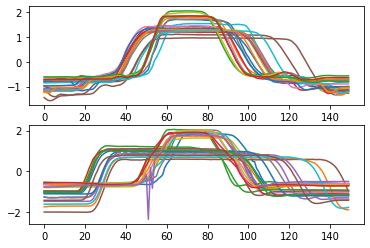

In [4]:
X_train.shape

fig, ax = plt.subplots(2)
ax[0].plot(X_train[y_train==1].T)
ax[1].plot(X_train[y_train==2].T)

In [5]:
X_train

array([[-0.6478854 , -0.64199155, -0.63818632, ..., -0.64042873,
        -0.63866571, -0.63865722],
       [-0.64442658, -0.64540093, -0.64705511, ..., -0.6349345 ,
        -0.6344968 , -0.63159565],
       [-0.77835282, -0.77827907, -0.77715084, ..., -0.70419626,
        -0.70760524, -0.7071202 ],
       ...,
       [-0.77912617, -0.77837863, -0.7757449 , ..., -0.50500603,
        -0.50373099, -0.50438486],
       [-0.70303339, -0.70261754, -0.70250356, ..., -0.64113375,
        -0.64140622, -0.64210896],
       [-1.4357199 , -1.4322717 , -1.4329285 , ..., -1.4354619 ,
        -1.4352821 , -1.4308845 ]])

In [3]:
def sampling(A,n):
    return A[np.random.randint(A.shape[0], size=n), :]
test = sampling(X_train,5)
test.shape

(5, 150)

In [4]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [8]:
x = X_train[:1]

windows = rolling_window(test,30)
print(windows.shape)

# distances = [mts.mass2(x.squeeze(), query) for query in windows.squeeze()]

# x.shape

(5, 121, 30)


1464100
CPU times: user 2.73 s, sys: 35.6 ms, total: 2.76 s
Wall time: 2.8 s


CPU times: user 105 ms, sys: 3.73 ms, total: 108 ms
Wall time: 107 ms


(1, 121, 30)

In [5]:
%%time


def get_candidate_mins(sample_data, shapelet_size = 10):
    """
    Function that calculates the distance of all candidates of a given data set to all all other candidates.
    CAREFUL:
    - memory blows up quickly.
    - contains the zeros (distance of candidates to itself)
    """
    windowed_data = rolling_window(sample_data, shapelet_size)
    return np.array([abs(windowed_data - series).sum(axis=-1) for series in windowed_data])

profiles = get_candidate_mins(X_train)

profiles.shape


CPU times: user 21.5 ms, sys: 4.52 ms, total: 26.1 ms
Wall time: 24.4 ms


(50, 50, 141)

In [10]:

%%time


from sklearn import svm
from sklearn.metrics import f1_score

def fit_svm(X,Y):
    """
    Fitting a SVM and returning the f1 score and the calculated margin.
    """
    clf = svm.SVC(kernel='linear')
    # Fit classifier
    clf.fit(X, Y)
    # Calculate margin
    margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
    # Predict
    Y_pred = clf.predict(X)
    # Calculate f1 score
    f1 = f1_score(Y,Y_pred)
    return f1, margin

def get_scores_for_profiles(profiles, y_train, scoring_function):
    """
    Computes the scores for each candidate for each sample in a population of profiles.
    Requires labels.
    """
    list_samples = []
    # Iterating through all smaples in a population of profiles
    for sample in range(profiles.shape[0]):
        # For each candidate in a given sample, compute the boundary and f1 score (SVM)
        sample_scores = [scoring_function(np.expand_dims(profiles[sample,:,cand],axis=1), y_train) for cand in range(profiles.shape[2])]
        list_samples.append(sample_scores)
    return np.array(list_samples)

samples_scores = get_scores_for_profiles(profiles, y_train, fit_svm)


CPU times: user 7.22 s, sys: 24.5 ms, total: 7.24 s
Wall time: 7.26 s


In [22]:

def closest_neighbor(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).sum(axis=1).argmin()
    return array[idx], idx

def hypothesis_margin(x, X_target, X_other):
    return 1/2*(abs(x - closest_neighbor(X_other, x)) - abs(x - closest_neighbor(X_target, x)))

def cumulative_margin(X, y, target_class):
    X_target = X[y == target_class]
    X_other = X[y != target_class]
    return sum([hypothesis_margin(x, np.delete(X_target,idx), X_other) for idx, x in enumerate(X_target)])

    # for idx, row in X_target.iterrows()
    # for x in X[y == target_class]:    
    #     margin = 1/2*(abs(x - closest_neighbor(X[y!=target_class], x)) - abs(x - closest_neighbor(X[y==target_class], x)))
    #     cumulative_margin += margin
    # return cumulative_margin

print(1,X_train.shape)

test_s = X_train[0]

result_s, result_i = closest_neighbor(X_train,test_s)

print(result_i)

hypothesis_margin(X_train, y_train, target_class=1)



# start = time.time()
# a = hypothesis_margin(X, y, 1)
# print(time.time()-start)

1 (50, 150)
0
(24, 150)


In [13]:
def hm_decorator(X,y):
    return hypothesis_margin(X,y,target_class=1)

smaples_score_hm = get_scores_for_profiles(profiles,y_train,hm_decorator)

In [14]:
samples_scores[0].shape

(141, 2)

In [4]:
%%time
class GreedyShapeletSearch():
    """
    F: a function that finds the 'best' candidate
        F: scores each (additional) profile
            F: evaluates the margin (h-margin)
                F: h-margin
            F: 1-nn classifier
                    - 1 NN
                    - sorting: not needed because applying to minority class (majority class does not get computed)
        F: find next greedy optimal shapelet
        - Store shapelet
        - store shapelet distances (feature vector)
    """
    def __init__(self):
        self.shapelets = []

    def find_n_shapelets(self, profiles, y_profiles, target_class, n_shapelets):
        for _ in range(n_shapelets):
            self.score_profiles(profiles,y_profiles,target_class)
    
    def score_profiles(self, profiles, y_profiles, target_class):
        optimal_score = 0
        optimal_margin = 0
        optimal_shapelet = 0
        
        for sample_idx in range(profiles.shape[0]):
            sample = profiles[sample_idx]
            for candidate_idx in range(sample.shape[1]):
                # If a shapelet has already been found, add previous values to features
                if len(self.shapelets)>0:
                    extra_features = [profiles[shapelet[2][0],:,shapelet[2][1]] for shapelet in self.shapelets]
                    extra_features.append(sample[:,candidate_idx])
                    features= np.array(extra_features).T
                # Else only use candidate values
                else:
                    features = sample[:,candidate_idx]
                margin, score =self.score_candidate(features, y_profiles, target_class=target_class)
                
                if score > optimal_score:
                    optimal_margin = margin
                    optimal_score = score
                    optimal_shapelet = (sample_idx, candidate_idx)
                elif score == optimal_score:
                    if margin > optimal_margin:
                        optimal_margin = margin
                        optimal_score = score
                        optimal_shapelet = (sample_idx, candidate_idx)
        self.shapelets.append((optimal_score, optimal_margin,optimal_shapelet))
                
    @staticmethod
    def closest_neighbor(array, value):
        if len(array.shape)==1:
            array = np.expand_dims(array,axis=1)
        idx = (np.abs(array - value)).sum(axis=1).argmin()
        return array[idx]
 
    def hypothesis_margin(self, x, X_target, X_other):
        return 1/2*(np.linalg.norm(x - self.closest_neighbor(X_other, x)) - np.linalg.norm(x - self.closest_neighbor(X_target, x)))
    
    def score_candidate(self, X, y, target_class):
        X_target = X[y == target_class]
        X_other = X[y != target_class]
        margins = [self.hypothesis_margin(x, np.delete(X_target,idx), X_other) for idx, x in enumerate(X_target)]
        cumulative_margin = sum(margins)
        score = len([margin for margin in margins if margin < 0])/len(margins)
        return cumulative_margin, score
    

    # def recursive_top_shapelet(self, profiles, y_train, scoring_function, additional_features = None, number_shapelets = 1):

    #     # Recursive event loop that finds an 'optimal' shapelet at each iteration
    #     while self.num_shapelets < number_shapelets:
    #         samples_score = self.get_scores_for_profiles(profiles, y_train, scoring_function, additional_features)
    #         f1_scores = samples_scores[:,:,0]
            
    #         margin_filtering
    #         best_sample_id = np.unravel_index(f1_scores.argmax(), f1_scores.shape)



    #         best_sample_features = profiles[best_sample_id[0],:,best_sample_id[1]]
    #         self.best_shapelets.append(best_sample_id)
    #         self.best_shapelets_features.append(best_sample_features)

    #         if len(self.best_shapelets_features) > 1:
    #             additional_features = np.concatenate(self.best_shapelets_features, axis=1)
    #         else:
    #             additional_features = best_sample_features
    #         self.num_shapelets += 1
    #         self.recursive_top_shapelet(profiles, y_train, scoring_function, additional_features, number_shapelets)
        
    #     return

    # def margin_filtering(self):
    #     pass


    # def get_scores_for_profiles(self,profiles, y_train, scoring_function, additional_features=None ):
    #     """
    #     Computes the scores for each candidate for each sample in a population of profiles.
    #     Requires labels.
    #     """
    #     list_samples = []
    #     # Iterating through all smaples in a population of profiles
    #     for sample in range(profiles.shape[0]):
    #         # For each candidate in a given sample, compute the boundary and f1 score (SVM)
    #         def feature_decorator(column):
    #             if additional_features:
    #                 return np.concatenate([additional_features,column], axis=1)
    #             return column

    #         sample_scores = [scoring_function(feature_decorator(np.expand_dims(profiles[sample,:,cand],axis=1)), y_train) for cand in range(profiles.shape[2])]
    #         list_samples.append(sample_scores)
    #     return np.array(list_samples)

GSS = GreedyShapeletSearch()
# GSS.score_profiles(profiles, y_train)

GSS.find_n_shapelets(profiles, y_train, 1, n_shapelets=2)


NameError: name 'profiles' is not defined

In [66]:
%%time

class GreedyShapeletSearch():
    def __init__(self):
        self.shapelets = []
        self.exclusion_zone = {}
        self.shapelet_size = 0

    @staticmethod
    def rolling_window(a, window):
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

    
    def get_candidate_mins(self, sample_data, shapelet_size = 10):
        """
        Function that calculates the distance of all candidates of a given data set to all all other candidates.
        CAREFUL:
        - memory blows up quickly.
        - contains the zeros (distance of candidates to itself)
        """
        windowed_data = self.rolling_window(sample_data, shapelet_size)
        # Standardize candidates
        windowed_data = self.standardize_samples_candidates(windowed_data)
  
        distances = []
        for sample_candidates in windowed_data:
            candidate_distances = np.array([((windowed_data - candidate)**2).sum(axis=-1).min(axis=-1) for candidate in sample_candidates])
            distances.append(candidate_distances)
        return np.stack(distances)


    def add_shapelet_features(self, candidate, profiles):
        """
        Adds the features of previous optimal shapelets to the current candidate features.
        """
        # If no shapelet has been found yet, just use the candidate feature
        if len(self.shapelets) == 0:
            return candidate
        extra_features = [profiles[shapelet[2][0],shapelet[2][1],:]for shapelet in self.shapelets]
        extra_features.append(candidate)
        return np.array(extra_features).T

    def score_candidate(self, candidate, y_train, target_class):
        """
        This function evaluates a candidate based on the hypothesis margin.
        """
        # Split dataset into target class and other
        candidates_target = candidate[y_train == target_class]
        candidates_other = candidate[y_train != target_class]

        return self.cumulative_hypothesis_margin(candidates_target, candidates_other)

    def cumulative_hypothesis_margin(self,candidates_target, candidates_other):
        """
        Calculate the cumulative margin.
        """
        # Compute the hypothesis margins for all candidates_target
        margins = [self.hypothesis_margin(x, np.delete(candidates_target,idx), candidates_other) for idx, x in enumerate(candidates_target)]
        # Normalize the margins
        # margins = self.normalize_margins(margins)
        # Sum of all margins
        cumulative_margin = sum(margins)
        # All margins that are positive mean that the nearest neighbor is of the same class
        score = len([margin for margin in margins if margin > 0])/len(margins) 
        return score, cumulative_margin

    @staticmethod
    def normalize_margins(margins):
        return (margins-min(margins))/(max(margins)-min(margins))

    @staticmethod
    def standardize_candidates(candidates):
        # return (candidates-candidates.min(axis=0))/(candidates.max(axis=0)-candidates.min(axis=0))
        return (candidates-candidates.mean(axis=0))/candidates.std(axis=0)
    
    @staticmethod
    def standardize_samples_candidates(samples, axis=2):
        """
        Standardized each shapelet candidate (after windowing).
        """

        return (samples-np.expand_dims(samples.mean(axis=axis),axis))/np.expand_dims(samples.std(axis=axis),axis)

    def hypothesis_margin(self, x, candidates_target, candidates_other):
        """
        Calculate the hypothesis margin for a candidate.
        """
        margin_other = self.closest_neighbor(candidates_other, x)
        margin_target = self.closest_neighbor(candidates_target, x)
        margin = 1/2*(margin_other - margin_target)
        return margin

    def closest_neighbor(self, candidates, x):
        """
        Find the distance to the closest neighbor
        """
        if len(candidates.shape) == 1:
            candidates = np.expand_dims(candidates,axis=1)
        min_distance = (np.linalg.norm(candidates - x)).min()
        return min_distance

    def fit_classifier(self, X_train, y_train, X_test, y_test, classifier, scoring_function):
        features_train = self.features_transform(X_train)
        classifier.fit(X_train, y_train)
        features_test = self.features_transform(X_test)
        y_pred = classifier.predict(X_test)
        return scoring_function(y_test, y_pred)


    def features_transform(self,X):
        shapelets = np.array([shapelet[3] for shapelet in self.shapelets])
        shapelets_sizes = [shapelet[4] for shapelet in self.shapelets]
        shapelets_norm = self.standardize_samples_candidates(shapelets.T,axis=1).T
        windowed_test = self.rolling_window(X, window=30)
        windowed_test_norm = self.standardize_samples_candidates(windowed_test)
        features_list = [(windowed_test_norm-shapelet).sum(axis=-1).min(axis=-1) for shapelet in shapelets_norm]
        features = np.array(features_list).T
        return features

    def main_event_loop(self, X_train, y_train, scoring_function, target_class = 1, n_shapelets=1, shapelet_min_size = 10, shapelet_max_size = 11):
        """
        The main event loop contains the series of steps required for the algorithm.
        """
        # Extract a shapelet for n_shapelets
        for n in range(n_shapelets):
            optimal_score = 0
            optimal_margin = 0
            optimal_shapelet = 0

            for shapelet_size in range(shapelet_min_size, shapelet_max_size):
                # Store shapelet size
                self.shapelet_size = shapelet_size
                # Calculate all of the candidate minimums throughout the dataset - shape: n_samples, n_samples, n_candidate
                profiles = self.get_candidate_mins(X_train, shapelet_size)
                
                # Iterate through all samples in profiles
                for sample_idx in range(profiles.shape[0]):
                    sample = profiles[sample_idx]
                    for candidate_idx in range(sample.shape[1]):
                        # Check if in exclusion zone
                        if sample_idx in self.exclusion_zone.keys():
                            if candidate_idx in self.exclusion_zone[sample_idx]:
                                continue
                        # The minimum distances of a candidate to all other samples
                        candidate = sample[candidate_idx,:]
                        candidate = self.add_shapelet_features(candidate, profiles)
                        candidate = self.standardize_candidates(candidate)
                        # Score candidate
                        score, margin = scoring_function(candidate, y_train, target_class)

                        if score > optimal_score:
                            optimal_margin = margin
                            optimal_score = score
                            optimal_shapelet = (sample_idx, candidate_idx)
                            optimal_shapelet_size = shapelet_size
                        elif score == optimal_score:
                            if margin > optimal_margin:
                                optimal_margin = margin
                                optimal_score = score
                                optimal_shapelet = (sample_idx, candidate_idx)
                                optimal_shapelet_size = shapelet_size
            # Adding the required shapelets
            self.shapelets.append(\
                (optimal_score, optimal_margin,optimal_shapelet, X_train[optimal_shapelet[0],\
                    optimal_shapelet[1]:(optimal_shapelet[1]+optimal_shapelet_size)], optimal_shapelet_size))
            
            if optimal_shapelet[0] in self.exclusion_zone.keys():
                self.exclusion_zone[optimal_shapelet[0]].extend(list(range(optimal_shapelet[1]-optimal_shapelet_size,optimal_shapelet[1]+optimal_shapelet_size)))
            else:
                self.exclusion_zone[optimal_shapelet[0]] = list(range(optimal_shapelet[1]-optimal_shapelet_size,optimal_shapelet[1]+optimal_shapelet_size))

            print(f"Found shapelet number {n}!")

    # def extract_optimal_shapelet(self, profiles, X_train, y_train, target_class):
    #     """
    #     Extracts a (greedy) optimal shapelet.
    #     """

    #     optimal_score = 0
    #     optimal_margin = 0
    #     optimal_shapelet = 0

        # Iterate through all samples in profiles
        # for sample_idx in range(profiles.shape[0]):
        #     # The minimum distances of the given samples candidates to all other samples - shape: n_samples, n_candidates
        #     sample = profiles[sample_idx]
        #     # Iterate through all candidate distances of the given sample
        #     for candidate_idx in range(sample.shape[1]):
        #         # Check if in exclusion zone
        #         if sample_idx in self.exclusion_zone.keys():
        #             if candidate_idx in self.exclusion_zone[sample_idx]:
        #                 continue
        #         # The minimum distances of a candidate to all other samples
        #         candidate = sample[:,candidate_idx]
        #         candidate = self.add_shapelet_features(candidate, profiles)
        #         candidate = self.standardize_candidates(candidate)
        #         # Score candidate
        #         score, margin = self.score_candidate(candidate, y_train, target_class)

        #         if score > optimal_score:
        #             optimal_margin = margin
        #             optimal_score = score
        #             optimal_shapelet = (sample_idx, candidate_idx)
        #         elif score == optimal_score:
        #             if margin > optimal_margin:
        #                 optimal_margin = margin
        #                 optimal_score = score
        #                 optimal_shapelet = (sample_idx, candidate_idx)
        # self.shapelets.append((optimal_score, optimal_margin,optimal_shapelet, X_train[optimal_shapelet[0],optimal_shapelet[1]:optimal_shapelet[1]+self.shapelet_size]))
        # self.exclusion_zone[optimal_shapelet[0]] = list(range(optimal_shapelet[1]-self.shapelet_size,optimal_shapelet[1]+self.shapelet_size))

GSS = GreedyShapeletSearch()
# GSS.main_event_loop(X_train, y_train, scoring_function = GSS.score_candidate, n_shapelets=5, shapelet_min_size=30, shapelet_max_size=40)
GSS.main_event_loop(X_train, y_train, scoring_function = infogain, n_shapelets=1, shapelet_min_size=30, shapelet_max_size=40)

Found shapelet number 0!
CPU times: user 37.5 s, sys: 4.9 s, total: 42.4 s
Wall time: 42.6 s


[(array([0.99884554]), 1.5902614641626758, (27, 11), array([-1.0797931 , -1.0791981 , -1.0786976 , -1.0691456 , -1.0443617 ,
       -1.0076163 , -0.95439177, -0.88780186, -0.82168508, -0.77998832,
       -0.75723197, -0.75367352, -0.74952845, -0.75025064, -0.73624742,
       -0.72603858, -0.72451178, -0.71695558, -0.7081843 , -0.69730643,
       -0.69117134, -0.69002608, -0.68246017, -0.67760379, -0.65861513,
       -0.59883531, -0.47760207, -0.33316507, -0.16649781,  0.00844283,
        0.16843516,  0.33074   ]), 32)]


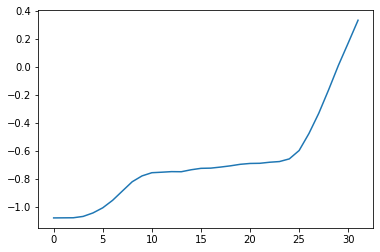

In [68]:
print(GSS.shapelets)

plt.plot(GSS.shapelets[0][3].T)

In [65]:
def infogain(candidate, y_train, y_target):
        """
        Given a 1-d array, calculates the infogain according the labels y_train.
        """
        if len(candidate.shape)==1:
            candidate = candidate.reshape(-1,1)
        # Initialize decision tree classifier
        clf = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=1)
        # Fit decision tree
        clf.fit(candidate, y_train)
        # Get entropy before best split
        entropy_before = clf.tree_.impurity[0]
        # Get entropy after best split
        entropy_after = clf.tree_.value.sum(-1)[1]/clf.tree_.value.sum(-1)[0] * clf.tree_.impurity[1] + \
            clf.tree_.value.sum(-1)[2]/clf.tree_.value.sum(-1)[0] * clf.tree_.impurity[2]

        # Calculate margin
        if len(set(y_train)) != 2:
            print(f"There is something wrong with the number of labels! The number o labels is {len(set(y_train))}.")
            raise ValueError
        label_avgs = [candidate[y_train==label].mean() for label in set(y_train)]
        margin = abs(label_avgs[0]-label_avgs[1])
        # Return information gain
        return entropy_before - entropy_after, margin


[0.96591539 0.88993447 0.90218229 0.83374242 0.86655242 0.88853262
 0.86223009 0.88481469 0.90874703 0.87326674 0.92338484 0.86163142
 0.88954173 0.90502582 0.95809615 0.89123302 0.91702087 0.90942137
 0.90940521 0.90275086 0.92186703 0.92306718 0.91116221 0.92954641
 0.91456446 0.91740343 0.94296919 0.93684124 0.93075769 0.91386939
 0.88801548 0.9364492  0.9364492  0.92549406]
34
[[ 2.06446172 -0.6438096  -0.20724711 -2.64672451 -1.47724167 -0.69377728
  -1.63130722 -0.82629954  0.02674712 -1.23791579  0.54849865 -1.65264627
  -0.65780846 -0.10589205  1.78575196 -0.59752396  0.32166068  0.05078336
   0.05020735 -0.18698095  0.49439768  0.53717594  0.11283403  0.76812225
   0.23410416  0.33529669  1.24656513  1.02813988  0.81129723  0.20932902
  -0.71221027  1.01416597  1.01416597  0.62367989]]
[[ 2.06446172 -0.6438096  -0.20724711 -2.64672451 -1.47724167 -0.69377728
  -1.63130722 -0.82629954  0.02674712 -1.23791579  0.54849865 -1.65264627
  -0.65780846 -0.10589205  1.78575196 -0.59752

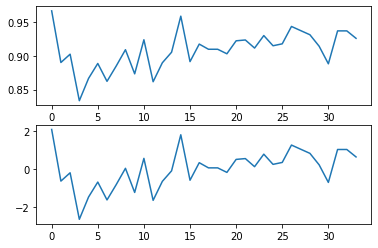

In [56]:
def features_transform(X):
    # return np.array([extract_features(X, shapelet, shapelet_size) for _,_,_,shapelet,shapelet_size in GSS.shapelets]).T
    for _,_,_,shapelet,shapelet_size in GSS.shapelets:
        print(shapelet)
        print(shapelet_size)
        print(extract_features(X, shapelet, shapelet_size))
        shapelet_norm = extract_features(X, shapelet, shapelet_size)
        fig, ax = plt.subplots(2)
        ax[0].plot(shapelet.T)
        ax[1].plot(shapelet_norm.T)
        return 
    # return np.array([extract_features(X, shapelet, shapelet_size) for _,_,_,shapelet,shapelet_size in GSS.shapelets]).T

def extract_features(X, shapelet, shapelet_size):
    shapelets_norm = GSS.standardize_samples_candidates(shapelet.reshape(-1,1),axis=0).T
    print(shapelets_norm)

    return shapelets_norm
    # windowed_test = GSS.rolling_window(X, window=shapelet_size)
    # windowed_test_norm = GSS.standardize_samples_candidates(windowed_test)
    # feature = (windowed_test_norm-shapelets_norm).sum(axis=-1).min(axis=-1)
    # return feature

features_train = features_transform(X_train)
# features_test = features_transform(X_test)
# print(features.shape)

In [52]:
features_train.shape

(50, 5)

In [53]:
# normalize
# GSS.standardize_samples_candidates(features_train)
def normalize_features(features_train, features_test):
    train_norm = (features_train-features_train.mean(axis=0))/features_train.std(axis=0)
    test_norm = (features_test-features_train.mean(axis=0))/features_train.std(axis=0)
    return train_norm, test_norm

# features_train = features_transform(X_train)
# features_test = features_transform(X_test)


features_train, features_test = normalize_features(features_transform(X_train), features_transform(X_test))

clf = SVC(kernel='linear')
# Fit classifier
clf.fit(features_train, y_train)
# Calculate margin
margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
# Predict
Y_pred_train = clf.predict(features_train)
Y_pred_test = clf.predict(features_test)
# Calculate f1 score
f1_train = f1_score(y_train,Y_pred_train)
f1_test = f1_score(y_test,Y_pred_test)

print(f"Train data f1 = {f1_train}, margin = {margin}")
print(f"Test data f1 = {f1_test}, margin = {margin}")

Train data f1 = 0.0, margin = 1.5057795949302157
Test data f1 = 0.0, margin = 1.5057795949302157


In [25]:
def fit_svm(X,Y, target_class):
    """
    Fitting a SVM and returning the f1 score and the calculated margin.
    """
    clf = SVC(kernel='linear')
    # Fit classifier
    if len(X.shape) == 1:
       X = X.reshape(-1, 1) 
    clf.fit(X, Y)
    # Calculate margin
    margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
    # Predict
    Y_pred = clf.predict(X)
    # Calculate f1 score
    f1 = f1_score(Y,Y_pred)
    return f1, margin

print(GSS.shapelets)
# GSS.exclusion_zone

[(1.0, 102.87528494869952, (36, 44), array([0.96591539, 0.88993447, 0.90218229, 0.83374242, 0.86655242,
       0.88853262, 0.86223009, 0.88481469, 0.90874703, 0.87326674,
       0.92338484, 0.86163142, 0.88954173, 0.90502582, 0.95809615,
       0.89123302, 0.91702087, 0.90942137, 0.90940521, 0.90275086,
       0.92186703, 0.92306718, 0.91116221, 0.92954641, 0.91456446,
       0.91740343, 0.94296919, 0.93684124, 0.93075769, 0.91386939,
       0.88801548, 0.9364492 , 0.9364492 , 0.92549406]), 34), (1.0, 108.45312404743409, (44, 43), array([1.0009117 , 1.0031457 , 0.99734632, 0.99646213, 0.99511897,
       0.99593582, 1.0035084 , 1.0035635 , 1.0044415 , 1.0047007 ,
       1.0041305 , 1.0067592 , 1.0117932 , 1.0064358 , 1.0155704 ,
       1.0127362 , 1.0148471 , 1.0138402 , 1.0206778 , 1.0134683 ,
       1.0177172 , 1.0204834 , 1.0139741 , 1.0124193 , 1.0094697 ,
       1.012985  , 1.0138289 , 1.0109009 , 1.0148811 , 1.0095742 ,
       1.0061392 , 1.0033153 , 1.0056185 , 1.0056185 , 0.9959

In [129]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
clf = svm.SVC(kernel='linear')
clf2 = RandomForestClassifier()

GSS.fit_classifier(X_train, y_train, X_test, y_test, clf2, accuracy_score)

0.9133333333333333

1. Calculate profiles
2. fit SVMs
3. find max candidate
4. exclude candidate
5. fit SVM
6. Repeat

Coding:

1. infogain berechnung fuer thresholds/ method / scoring function

2. decision tree classifier

In [44]:
print(GSS.best_shapelets)
print(GSS.best_shapelets_features)

[(15, 37)]
[array([ 6.81293176,  6.33589777,  6.61522386,  5.81805513,  5.62354658,
        6.21065083,  8.37324814,  5.54907378, 10.51779302,  3.66121551,
        3.9262708 ,  0.81486079,  5.17865678,  4.39626764,  6.14421592,
        0.        ,  7.76307171,  6.74248755,  1.96920595,  9.88983972,
        6.82150822,  2.39242716,  1.46722093,  6.39036219,  5.58556559,
       11.88209822,  3.97477105,  1.88594475,  9.96233332,  5.30729854,
        6.00522334,  7.74716749, 10.64058272,  5.97953477,  6.42642412,
        5.79702106,  9.09567517,  6.18469961,  6.40200599,  9.4120621 ,
        7.00428814,  6.01016935,  5.56165691,  2.05150548,  9.61590966,
        6.10445358,  6.06759333,  7.20805343,  6.34922222,  7.45935446])]


In [46]:
# 

In [16]:
%%time

class ShapeletTransform():
    def __init__(self):
        self.shapelets = []
        self.exclusion_zone = {}
        self.shapelet_size = 0

    @staticmethod
    def rolling_window(a, window):
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

    
    def get_candidate_mins(self, sample_data, shapelet_size = 10):
        """
        Function that calculates the distance of all candidates of a given data set to all all other candidates.
        CAREFUL:
        - memory blows up quickly.
        - contains the zeros (distance of candidates to itself)
        """
        # Window the array
        windowed_data = self.rolling_window(sample_data, shapelet_size)
        # Standardize candidates
        windowed_data = self.standardize_samples_candidates(windowed_data)
        distances = []
        for sample_candidates in windowed_data:
            candidate_distances = np.array([((windowed_data - candidate)**2).sum(axis=-1).min(axis=-1) for candidate in sample_candidates])
            distances.append(candidate_distances)
        return np.stack(distances)
        # print(np.stack(distances).shape)
        # return np.array([abs(windowed_data - series).sum(axis=-1) for series in windowed_data])
    

    def get_top_k_shapelets(self, X_train, y_train, n_shapelets=1, shapelet_min_size = 10, shapelet_max_size=20):

        top_shapelets = []
        for shapelet_size in range(shapelet_min_size,shapelet_max_size):
            self.main_event_loop(X_train, y_train, n_shapelets, shapelet_size)
            top_shapelets.extend([(sample_idx, candidate_idx, info_gain, margin, shapelet, shapelet_size) for sample_idx, candidate_idx, info_gain, margin, shapelet in self.top_shapelets])
        self.shapelets = top_shapelets
        self.shapelets.sort(key=lambda x: (x[2],x[3]), reverse=True)

        self.exclusion_zone = {}
        # Apply exclusion zone and selecting the top n_shapelets
        top_shapelets = []
        n_shapelets_found = 0
        # Iterate over all shapelet candidates
        for sample_idx, candidate_idx, info_gain, margin, shapelet, shapelet_size in self.shapelets:
            # If the correct number of shapelets was found, break out of loop
            if n_shapelets_found == n_shapelets:
                break
            # Check if sample index of candidate in exclusion zone samples
            if sample_idx not in self.exclusion_zone.keys():
                self.exclusion_zone[sample_idx] = []
            else:
                # Otherwise check if candidate index is in exclusion zone of sample
                if candidate_idx in self.exclusion_zone[sample_idx]:
                    continue
            self.exclusion_zone[sample_idx].extend(list(range(candidate_idx - self.shapelet_size, candidate_idx+self.shapelet_size)))
            top_shapelets.append((sample_idx, candidate_idx, info_gain, margin, shapelet, shapelet_size))
            n_shapelets_found += 1
        self.top_shapelets = top_shapelets




    def main_event_loop(self, X_train, y_train, n_shapelets=1, shapelet_size = 10):
        """
        The main event loop contains the series of steps required for the algorithm.
        """
        # Store shapelet size
        self.shapelet_size = shapelet_size
        # Calculate all of the candidate minimums throughout the dataset - shape: n_samples, n_samples, n_candidate
        profiles = self.get_candidate_mins(X_train, shapelet_size)
        # Extract a shapelet for n_shapelets
        self.extract_shapelets(profiles, X_train, y_train)
        # Sort shapelets according to info gain descending
        self.shapelets.sort(key=lambda x: (x[2],x[3]), reverse=True)
        # Retrieve top shapelets
        self.retrieve_top_shapelets(X_train, n_shapelets)


    def retrieve_top_shapelets(self, X_train, n_shapelets):
        # Apply exclusion zone and selecting the top n_shapelets
        top_shapelets = []
        n_shapelets_found = 0
        self.exclusion_zone = {}
        # Iterate over all shapelet candidates
        for sample_idx, candidate_idx, info_gain, margin in self.shapelets:
            # If the correct number of shapelets was found, break out of loop
            if n_shapelets_found == n_shapelets:
                break
            # Check if sample index of candidate in exclusion zone samples
            if sample_idx not in self.exclusion_zone.keys():
                self.exclusion_zone[sample_idx] = []
            else:
                # Otherwise check if candidate index is in exclusion zone of sample
                if candidate_idx in self.exclusion_zone[sample_idx]:
                    continue
            self.exclusion_zone[sample_idx].extend(list(range(candidate_idx - self.shapelet_size, candidate_idx+self.shapelet_size)))
            top_shapelets.append((sample_idx, candidate_idx, info_gain, margin, X_train[sample_idx,candidate_idx:candidate_idx+self.shapelet_size]))
            n_shapelets_found += 1
        self.top_shapelets = top_shapelets

    def extract_shapelets(self, profiles, X_train, y_train):
        """
        Extracts a (greedy) optimal shapelet.
        """
        # Iterate through all samples in profiles
        for sample_idx in range(profiles.shape[0]):
            # The minimum distances of the given samples candidates to all other samples - shape: n_samples, n_candidates
            sample = profiles[sample_idx]
            # Iterate through all candidate distances of the given sample
            for candidate_idx in range(sample.shape[0]):
                # The minimum distances of a candidate to all other samples
                candidate = sample[candidate_idx,:]
                # Score candidate
                info_gain, margin = self.calculate_infogain(candidate.reshape((50,1)), y_train)
                self.shapelets.append((sample_idx, candidate_idx, info_gain, margin))
                

    def calculate_infogain(self, candidate, y_train):
        """
        Given a 1-d array, calculates the infogain according the labels y_train.
        """
        # Initialize decision tree classifier
        clf = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=1)
        # Fit decision tree
        clf.fit(candidate, y_train)
        # Get entropy before best split
        entropy_before = clf.tree_.impurity[0]
        # Get entropy after best split
        entropy_after = clf.tree_.value.sum(-1)[1]/clf.tree_.value.sum(-1)[0] * clf.tree_.impurity[1] + \
            clf.tree_.value.sum(-1)[2]/clf.tree_.value.sum(-1)[0] * clf.tree_.impurity[2]

        # Calculate margin
        if len(set(y_train)) != 2:
            print(f"There is something wrong with the number of labels! The number o labels is {len(set(y_train))}.")
            raise ValueError
        label_avgs = [candidate[y_train==label].mean() for label in set(y_train)]
        margin = abs(label_avgs[0]-label_avgs[1])
        # Return information gain
        return entropy_before - entropy_after, margin

    @staticmethod
    def standardize_samples_candidates(samples, axis=2):
        """
        Standardized each shapelet candidate (after windowing).
        """
        return (samples-np.expand_dims(samples.mean(axis=axis),axis))/np.expand_dims(samples.std(axis=axis),axis)

    def fit_classifier(self, X_train, y_train, X_test, y_test, classifier, scoring_function):
        """
        Tests the performance of a classifier that is first trained  and then tested according to a specified scoring function.
        """
        features_train = self.features_transform(X_train)
        classifier.fit(X_train, y_train)
        features_test = self.features_transform(X_test)
        y_pred = classifier.predict(X_test)
        return scoring_function(y_test, y_pred)


    def features_transform(self,X):
        """
        Transformation pipeline for a new dataset X
        """
        # Retrieve all shapelets
        shapelets = np.array([shapelet[3] for shapelet in self.top_shapelets])
        # Standardize the shapelets
        shapelets_norm = self.standardize_samples_candidates(shapelets.T,axis=1).T
        # Window the data
        windowed_test = self.rolling_window(X, window=self.shapelet_size)
        # Normalize the windowed data
        windowed_test_norm = self.standardize_samples_candidates(windowed_test)
        # Calculate the features (get min shapelet distances of all shapelets to all samples)
        features_list = [(windowed_test_norm-shapelet).sum(axis=-1).min(axis=-1) for shapelet in shapelets_norm]
        features = np.array(features_list).T
        return features

ST = ShapeletTransform()
# ST.main_event_loop(X_train, y_train, n_shapelets=5, shapelet_size=38)
ST.get_top_k_shapelets(X_train, y_train, n_shapelets=10, shapelet_min_size = 30, shapelet_max_size=40)

CPU times: user 1min 2s, sys: 5.16 s, total: 1min 7s
Wall time: 1min 7s


In [15]:
# 
ST.top_shapelets

# features = ST.features_transform(X_train)
# features.shape


def features_transform(X_train, X):
    """
    Transformation pipeline for a new dataset X
    """
    features =  []
    for sample_idx, candidate_idx, _,_,_, shapelet_size in ST.top_shapelets:
        # Extract shapelet from training data
        shapelet = X_train[sample_idx, candidate_idx:candidate_idx+shapelet_size]
        # Normalize shapelet
        shapelet_norm = ST.standardize_samples_candidates(shapelet, axis=0)
        # Window the data
        windowed_test = ST.rolling_window(X, window=shapelet_size)
        # Normalize the windowed data
        windowed_test_norm = ST.standardize_samples_candidates(windowed_test)
        # Calculate features for shapelet and X
        shapelet_features = (windowed_test_norm-shapelet_norm).sum(axis=-1).min(axis=-1)
        features.append(shapelet_features)
    return np.array(features).T

features = features_transform(X_train, X_train)
print(features.shape)
# print(features)


def fit_classifier(X_train, y_train, X_test, y_test, classifier, scoring_function):
    """
    Tests the performance of a classifier that is first trained  and then tested according to a specified scoring function.
    """
    features_train = features_transform(X_train, X_train)
    classifier.fit(features_train, y_train)
    features_test = features_transform(X_train, X_test)
    y_pred = classifier.predict(features_test)
    return scoring_function(y_test, y_pred)


from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

# clf = SVC(kernel='linear')
clf = make_pipeline(StandardScaler(), SVC(kernel='linear',class_weight='balanced'))



fit_classifier(X_train, y_train, X_test, y_test, clf, f1_score)

(50, 3)


0.6990291262135921

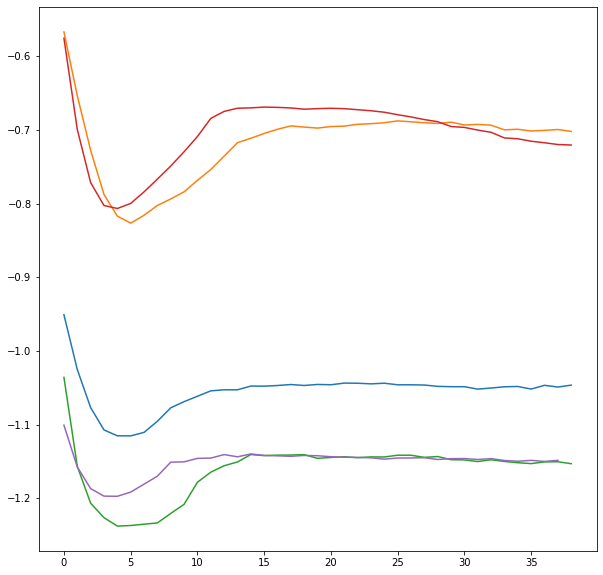

In [21]:
fig, ax = plt.subplots(figsize=(10,10))

for _,_,_,_,shapelet,_ in ST.top_shapelets:
    ax.plot(shapelet)


In [11]:
class GreedyShapeletSearch():
    def __init__(self):
        self.shapelets = []
        self.exclusion_zone = {}
        self.shapelet_size = 0

    @staticmethod
    def rolling_window(a, window):
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

    
    def get_candidate_mins(self, sample_data, shapelet_size = 10):
        """
        Function that calculates the distance of all candidates of a given data set to all all other candidates.
        CAREFUL:
        - memory blows up quickly.
        - contains the zeros (distance of candidates to itself)
        """
        # Window the array
        windowed_data = self.rolling_window(sample_data, shapelet_size)
        # Standardize candidates
        windowed_data = self.standardize_samples_candidates(windowed_data)
        distances = []
        for sample_candidates in windowed_data:
            candidate_distances = np.array([((windowed_data - candidate)**2).sum(axis=-1).min(axis=-1) for candidate in sample_candidates])
            distances.append(candidate_distances)
        return np.stack(distances)
        # print(np.stack(distances).shape)
        # return np.array([abs(windowed_data - series).sum(axis=-1) for series in windowed_data])
    

    def get_top_k_shapelets(self, X_train, y_train, n_shapelets=1, shapelet_min_size = 10, shapelet_max_size=20):

        top_shapelets = []
        for shapelet_size in range(shapelet_min_size,shapelet_max_size):
            self.main_event_loop(X_train, y_train, n_shapelets, shapelet_size)
            top_shapelets.extend([(sample_idx, candidate_idx, info_gain, margin, shapelet, shapelet_size) for sample_idx, candidate_idx, info_gain, margin, shapelet in self.top_shapelets])
        self.shapelets = top_shapelets
        self.shapelets.sort(key=lambda x: (x[2],x[3]), reverse=True)

        self.exclusion_zone = {}
        # Apply exclusion zone and selecting the top n_shapelets
        top_shapelets = []
        n_shapelets_found = 0
        # Iterate over all shapelet candidates
        for sample_idx, candidate_idx, info_gain, margin, shapelet, shapelet_size in self.shapelets:
            # If the correct number of shapelets was found, break out of loop
            if n_shapelets_found == n_shapelets:
                break
            # Check if sample index of candidate in exclusion zone samples
            if sample_idx not in self.exclusion_zone.keys():
                self.exclusion_zone[sample_idx] = []
            else:
                # Otherwise check if candidate index is in exclusion zone of sample
                if candidate_idx in self.exclusion_zone[sample_idx]:
                    continue
            self.exclusion_zone[sample_idx].extend(list(range(candidate_idx - self.shapelet_size, candidate_idx+self.shapelet_size)))
            top_shapelets.append((sample_idx, candidate_idx, info_gain, margin, shapelet, shapelet_size))
            n_shapelets_found += 1
        self.top_shapelets = top_shapelets




    def main_event_loop(self, X_train, y_train, n_shapelets=1, shapelet_size = 10):
        """
        The main event loop contains the series of steps required for the algorithm.
        """
        # Store shapelet size
        self.shapelet_size = shapelet_size
        # Calculate all of the candidate minimums throughout the dataset - shape: n_samples, n_samples, n_candidate
        profiles = self.get_candidate_mins(X_train, shapelet_size)
        # Extract a shapelet for n_shapelets
        self.extract_shapelets(profiles, X_train, y_train)
        # Sort shapelets according to info gain descending
        self.shapelets.sort(key=lambda x: (x[2],x[3]), reverse=True)
        # Retrieve top shapelets
        self.retrieve_top_shapelets(X_train, n_shapelets)


    def retrieve_top_shapelets(self, X_train, n_shapelets):
        # Apply exclusion zone and selecting the top n_shapelets
        top_shapelets = []
        n_shapelets_found = 0
        self.exclusion_zone = {}
        # Iterate over all shapelet candidates
        for sample_idx, candidate_idx, info_gain, margin in self.shapelets:
            # If the correct number of shapelets was found, break out of loop
            if n_shapelets_found == n_shapelets:
                break
            # Check if sample index of candidate in exclusion zone samples
            if sample_idx not in self.exclusion_zone.keys():
                self.exclusion_zone[sample_idx] = []
            else:
                # Otherwise check if candidate index is in exclusion zone of sample
                if candidate_idx in self.exclusion_zone[sample_idx]:
                    continue
            self.exclusion_zone[sample_idx].extend(list(range(candidate_idx - self.shapelet_size, candidate_idx+self.shapelet_size)))
            top_shapelets.append((sample_idx, candidate_idx, info_gain, margin, X_train[sample_idx,candidate_idx:candidate_idx+self.shapelet_size]))
            n_shapelets_found += 1
        self.top_shapelets = top_shapelets

    def extract_shapelets(self, profiles, X_train, y_train):
        """
        Extracts a (greedy) optimal shapelet.
        """
        # Iterate through all samples in profiles
        for sample_idx in range(profiles.shape[0]):
            # The minimum distances of the given samples candidates to all other samples - shape: n_samples, n_candidates
            sample = profiles[sample_idx]
            # Iterate through all candidate distances of the given sample
            for candidate_idx in range(sample.shape[0]):
                # The minimum distances of a candidate to all other samples
                candidate = sample[candidate_idx,:]
                # Score candidate
                info_gain, margin = self.calculate_infogain(candidate.reshape((50,1)), y_train)
                self.shapelets.append((sample_idx, candidate_idx, info_gain, margin))
                

    def calculate_infogain(self, candidate, y_train):
        """
        Given a 1-d array, calculates the infogain according the labels y_train.
        """
        # Initialize decision tree classifier
        clf = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=1)
        # Fit decision tree
        clf.fit(candidate, y_train)
        # Get entropy before best split
        entropy_before = clf.tree_.impurity[0]
        # Get entropy after best split
        entropy_after = clf.tree_.value.sum(-1)[1]/clf.tree_.value.sum(-1)[0] * clf.tree_.impurity[1] + \
            clf.tree_.value.sum(-1)[2]/clf.tree_.value.sum(-1)[0] * clf.tree_.impurity[2]

        # Calculate margin
        if len(set(y_train)) != 2:
            print(f"There is something wrong with the number of labels! The number o labels is {len(set(y_train))}.")
            raise ValueError
        label_avgs = [candidate[y_train==label].mean() for label in set(y_train)]
        margin = abs(label_avgs[0]-label_avgs[1])
        # Return information gain
        return entropy_before - entropy_after, margin

    @staticmethod
    def standardize_samples_candidates(samples, axis=2):
        """
        Standardized each shapelet candidate (after windowing).
        """
        return (samples-np.expand_dims(samples.mean(axis=axis),axis))/np.expand_dims(samples.std(axis=axis),axis)

    def fit_classifier(self, X_train, y_train, X_test, y_test, classifier, scoring_function):
        """
        Tests the performance of a classifier that is first trained  and then tested according to a specified scoring function.
        """
        features_train = self.features_transform(X_train)
        classifier.fit(X_train, y_train)
        features_test = self.features_transform(X_test)
        y_pred = classifier.predict(X_test)
        return scoring_function(y_test, y_pred)


    def features_transform(self,X):
        """
        Transformation pipeline for a new dataset X
        """
        # Retrieve all shapelets
        shapelets = np.array([shapelet[3] for shapelet in self.top_shapelets])
        # Standardize the shapelets
        shapelets_norm = self.standardize_samples_candidates(shapelets.T,axis=1).T
        # Window the data
        windowed_test = self.rolling_window(X, window=self.shapelet_size)
        # Normalize the windowed data
        windowed_test_norm = self.standardize_samples_candidates(windowed_test)
        # Calculate the features (get min shapelet distances of all shapelets to all samples)
        features_list = [(windowed_test_norm-shapelet).sum(axis=-1).min(axis=-1) for shapelet in shapelets_norm]
        features = np.array(features_list).T
        return features

ST = ShapeletTransform()
# ST.main_event_loop(X_train, y_train, n_shapelets=5, shapelet_size=38)
ST.get_top_k_shapelets(X_train, y_train, n_shapelets=3, shapelet_min_size = 30, shapelet_max_size=40)

In [12]:
ST.top_shapelets

[(8,
  105,
  array([0.99884554]),
  31.226651089786735,
  array([-0.95079668, -1.025098  , -1.0767507 , -1.107045  , -1.1150216 ,
         -1.1150928 , -1.1104016 , -1.0952914 , -1.0770713 , -1.0687018 ,
         -1.0613745 , -1.0540497 , -1.0526052 , -1.0526178 , -1.0475158 ,
         -1.0476689 , -1.0467752 , -1.0454486 , -1.0467271 , -1.0453529 ,
         -1.0457445 , -1.043518  , -1.043689  , -1.0445401 , -1.0436696 ,
         -1.0458034 , -1.0458095 , -1.0461388 , -1.0479577 , -1.0483777 ,
         -1.0483875 , -1.0516842 , -1.0501935 , -1.048496  , -1.0481063 ,
         -1.0516028 , -1.0465114 , -1.0488709 , -1.0462954 ]),
  39),
 (5,
  100,
  array([0.99884554]),
  22.34179593514275,
  array([-0.56701653, -0.65346671, -0.72769203, -0.78754067, -0.81694721,
         -0.82648644, -0.81580046, -0.8024913 , -0.79366331, -0.78399394,
         -0.76841397, -0.75374622, -0.73558646, -0.71730275, -0.7113566 ,
         -0.70475488, -0.69913498, -0.69454494, -0.69617677, -0.69751363,
   

In [ ]:
%%time

class ShapeletTransform():
    def __init__(self):
        self.shapelets = []
        self.exclusion_zone = {}
        self.shapelet_size = 0

    @staticmethod
    def rolling_window(a, window):
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

    
    def get_candidate_mins(self, sample_data, shapelet_size = 10):
        """
        Function that calculates the distance of all candidates of a given data set to all all other candidates.
        CAREFUL:
        - memory blows up quickly.
        - contains the zeros (distance of candidates to itself)
        """
        # Window the array
        windowed_data = self.rolling_window(sample_data, shapelet_size)
        # Standardize candidates
        windowed_data = self.standardize_samples_candidates(windowed_data)
        distances = []
        for sample_candidates in windowed_data:
            candidate_distances = np.array([((windowed_data - candidate)**2).sum(axis=-1).min(axis=-1) for candidate in sample_candidates])
            distances.append(candidate_distances)
        return np.stack(distances)
        # print(np.stack(distances).shape)
        # return np.array([abs(windowed_data - series).sum(axis=-1) for series in windowed_data])
    

    def get_top_k_shapelets(self, X_train, y_train, n_shapelets=1, shapelet_min_size = 10, shapelet_max_size=20):

        top_shapelets = []
        for shapelet_size in range(shapelet_min_size,shapelet_max_size):
            self.main_event_loop(X_train, y_train, n_shapelets, shapelet_size)
            top_shapelets.extend([(sample_idx, candidate_idx, info_gain, margin, shapelet, shapelet_size) for sample_idx, candidate_idx, info_gain, margin, shapelet in self.top_shapelets])
        self.shapelets = top_shapelets
        self.shapelets.sort(key=lambda x: (x[2],x[3]), reverse=True)

        self.exclusion_zone = {}
        # Apply exclusion zone and selecting the top n_shapelets
        top_shapelets = []
        n_shapelets_found = 0
        # Iterate over all shapelet candidates
        for sample_idx, candidate_idx, info_gain, margin, shapelet, shapelet_size in self.shapelets:
            # If the correct number of shapelets was found, break out of loop
            if n_shapelets_found == n_shapelets:
                break
            # Check if sample index of candidate in exclusion zone samples
            if sample_idx not in self.exclusion_zone.keys():
                self.exclusion_zone[sample_idx] = []
            else:
                # Otherwise check if candidate index is in exclusion zone of sample
                if candidate_idx in self.exclusion_zone[sample_idx]:
                    continue
            self.exclusion_zone[sample_idx].extend(list(range(candidate_idx - self.shapelet_size, candidate_idx+self.shapelet_size)))
            top_shapelets.append((sample_idx, candidate_idx, info_gain, margin, shapelet, shapelet_size))
            n_shapelets_found += 1
        self.top_shapelets = top_shapelets




    def main_event_loop(self, X_train, y_train, n_shapelets=1, shapelet_size = 10):
        """
        The main event loop contains the series of steps required for the algorithm.
        """
        # Store shapelet size
        self.shapelet_size = shapelet_size
        # Calculate all of the candidate minimums throughout the dataset - shape: n_samples, n_samples, n_candidate
        profiles = self.get_candidate_mins(X_train, shapelet_size)
        # Extract a shapelet for n_shapelets
        self.extract_shapelets(profiles, X_train, y_train)
        # Sort shapelets according to info gain descending
        self.shapelets.sort(key=lambda x: (x[2],x[3]), reverse=True)
        # Retrieve top shapelets
        self.retrieve_top_shapelets(X_train, n_shapelets)


    def retrieve_top_shapelets(self, X_train, n_shapelets):
        # Apply exclusion zone and selecting the top n_shapelets
        top_shapelets = []
        n_shapelets_found = 0
        self.exclusion_zone = {}
        # Iterate over all shapelet candidates
        for sample_idx, candidate_idx, info_gain, margin in self.shapelets:
            # If the correct number of shapelets was found, break out of loop
            if n_shapelets_found == n_shapelets:
                break
            # Check if sample index of candidate in exclusion zone samples
            if sample_idx not in self.exclusion_zone.keys():
                self.exclusion_zone[sample_idx] = []
            else:
                # Otherwise check if candidate index is in exclusion zone of sample
                if candidate_idx in self.exclusion_zone[sample_idx]:
                    continue
            self.exclusion_zone[sample_idx].extend(list(range(candidate_idx - self.shapelet_size, candidate_idx+self.shapelet_size)))
            top_shapelets.append((sample_idx, candidate_idx, info_gain, margin, X_train[sample_idx,candidate_idx:candidate_idx+self.shapelet_size]))
            n_shapelets_found += 1
        self.top_shapelets = top_shapelets

    def extract_shapelets(self, profiles, X_train, y_train):
        """
        Extracts a (greedy) optimal shapelet.
        """
        # Iterate through all samples in profiles
        for sample_idx in range(profiles.shape[0]):
            # The minimum distances of the given samples candidates to all other samples - shape: n_samples, n_candidates
            sample = profiles[sample_idx]
            # Iterate through all candidate distances of the given sample
            for candidate_idx in range(sample.shape[0]):
                # The minimum distances of a candidate to all other samples
                candidate = sample[candidate_idx,:]
                # Score candidate
                info_gain, margin = self.calculate_infogain(candidate.reshape((50,1)), y_train)
                self.shapelets.append((sample_idx, candidate_idx, info_gain, margin))
                

    def calculate_infogain(self, candidate, y_train):
        """
        Given a 1-d array, calculates the infogain according the labels y_train.
        """
        # Initialize decision tree classifier
        clf = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=1)
        # Fit decision tree
        clf.fit(candidate, y_train)
        # Get entropy before best split
        entropy_before = clf.tree_.impurity[0]
        # Get entropy after best split
        entropy_after = clf.tree_.value.sum(-1)[1]/clf.tree_.value.sum(-1)[0] * clf.tree_.impurity[1] + \
            clf.tree_.value.sum(-1)[2]/clf.tree_.value.sum(-1)[0] * clf.tree_.impurity[2]

        # Calculate margin
        if len(set(y_train)) != 2:
            print(f"There is something wrong with the number of labels! The number o labels is {len(set(y_train))}.")
            raise ValueError
        label_avgs = [candidate[y_train==label].mean() for label in set(y_train)]
        margin = abs(label_avgs[0]-label_avgs[1])
        # Return information gain
        return entropy_before - entropy_after, margin

    @staticmethod
    def standardize_samples_candidates(samples, axis=2):
        """
        Standardized each shapelet candidate (after windowing).
        """
        return (samples-np.expand_dims(samples.mean(axis=axis),axis))/np.expand_dims(samples.std(axis=axis),axis)

    def fit_classifier(self, X_train, y_train, X_test, y_test, classifier, scoring_function):
        """
        Tests the performance of a classifier that is first trained  and then tested according to a specified scoring function.
        """
        features_train = self.features_transform(X_train)
        classifier.fit(X_train, y_train)
        features_test = self.features_transform(X_test)
        y_pred = classifier.predict(X_test)
        return scoring_function(y_test, y_pred)


    def features_transform(self,X):
        """
        Transformation pipeline for a new dataset X
        """
        # Retrieve all shapelets
        shapelets = np.array([shapelet[3] for shapelet in self.top_shapelets])
        # Standardize the shapelets
        shapelets_norm = self.standardize_samples_candidates(shapelets.T,axis=1).T
        # Window the data
        windowed_test = self.rolling_window(X, window=self.shapelet_size)
        # Normalize the windowed data
        windowed_test_norm = self.standardize_samples_candidates(windowed_test)
        # Calculate the features (get min shapelet distances of all shapelets to all samples)
        features_list = [(windowed_test_norm-shapelet).sum(axis=-1).min(axis=-1) for shapelet in shapelets_norm]
        features = np.array(features_list).T
        return features

ST = ShapeletTransform()
# ST.main_event_loop(X_train, y_train, n_shapelets=5, shapelet_size=38)
ST.get_top_k_shapelets(X_train, y_train, n_shapelets=1, shapelet_min_size = 30, shapelet_max_size=40)